# Project for 42186 Model-based Machine Learning F21  

## PGM in Intrusion Detection System

### Notebook - GMVAE (K=2)

The KDDCUP99 10 percent dataset from the UCI repository. [1] It is a benchmark dataset for the evaluation of network Intrusion Detection System including the records of normal and malicious traffics. It contains 494021 samples in total with 42 dimensions. 

The target for this project is to consider intrusion detection as a classification problem without time as parameter over the dataset. Considering the multiple features in this dataset and referring to the GMVAE work in paper https://arxiv.org/pdf/1611.02648.pdf, the Variational Autoencoders (VAE) is tried in this notebook to be added into GMM to get GMVAE model, so that to utilize the idea of latent variable in deep generative model like VAE. This notebook studies if this model structure can help improve the coarse-grained results in notebook GMM (K=2) where the dataset samples are classified into normal/abnormal. 

\* Note that, due to the GPU timeout issues in Colab, this model is run with local CPU. 

[1] http://kdd.ics.uci.edu/databases/kddcup99/

# **Preparation**

Import required libraries Pyro:

In [ ]:
# Install Pyro, if necessary
!pip install pyro-ppl

Import the necessary packages

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch
import torch.autograd as autograd

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import SVI, TraceEnum_ELBO, JitTrace_ELBO, config_enumerate, infer_discrete
from pyro.infer.autoguide import AutoDelta
from pyro import poutine

import torch
import torch.nn as nn

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

**Load the dataset from local folder**

Based on the printed statistics and information, the dataset contains 494021 samples in total with 42 dimensions, where the first 41 of them are the features of network traffic and the last dimension is the label to indicate whether the traffic is normal or not. The 41 features are collected by directly extracting from the network traffic flow like the src_bytes, or by computing with a two-second time window like the serror_rate. For these 41 features, they are in the form of continuous, discrete or symbolic with the ranges varying widely. 

In [ ]:
# load csv
data = pd.read_csv("/home/fotonik208/mbml/kddcup.data_10_percent_corrected", header=None,names=['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'type'])
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [ ]:
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
duration                       494021 non-null int64
protocol_type                  494021 non-null object
service                        494021 non-null object
flag                           494021 non-null object
src_bytes                      494021 non-null int64
dst_bytes                      494021 non-null int64
land                           494021 non-null int64
wrong_fragment                 494021 non-null int64
urgent                         494021 non-null int64
hot                            494021 non-null int64
num_failed_logins              494021 non-null int64
logged_in                      494021 non-null int64
num_compromised                494021 non-null int64
root_shell                     494021 non-null int64
su_attempted                   494021 non-null int64
num_root                       494021 non-null int64
num_file_creations             494021 

The dataset includes the traffic records with the normal traffics and 22 type of attacks. Among these records, only around 20% of the records are the normal ones and the rest 80% are the abnormal ones.

In [ ]:
proportions = data["type"].value_counts()
print(proportions)
normal_data_count = data["type"].loc[data["type"]=="normal."].value_counts()
print(normal_data_count)
print("Anomaly Percentage", normal_data_count / proportions.sum())

smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: type, dtype: int64
normal.    97278
Name: type, dtype: int64
Anomaly Percentage normal.    0.196911
Name: type, dtype: float64


# **Preprocessing**

Data encoding:

To do the binary clustering, the label with different type of attacks need to be encoded into abnormal/normal. 

In [ ]:
# Encode the dataset label into binary format: abnormal (0)/normal (1)
data.loc[data["type"] != "normal.", 'type'] = 0
data.loc[data["type"] == "normal.", 'type'] = 1

In [ ]:
# check the binary encoding results

proportions = data["type"].value_counts()
print(proportions)
print("Anomaly Percentage",proportions[1] / proportions.sum())

0    396743
1     97278
Name: type, dtype: int64
Anomaly Percentage 0.19691065764410826


Since the featrues are saved in different format in the dataset and it's hard to process the features recorded as object. Thus, the one-hot encoding is done to these features to encode them into numerical values. 

In [ ]:
# One-hot encoding the data int numerical values

one_hot_protocol = pd.get_dummies(data["protocol_type"])
one_hot_service = pd.get_dummies(data["service"])
one_hot_flag = pd.get_dummies(data["flag"])

data = data.drop("protocol_type",axis=1)
data = data.drop("service",axis=1)
data = data.drop("flag",axis=1)
    
data = pd.concat([one_hot_protocol, one_hot_service,one_hot_flag, data],axis=1)
data.head()

,icmp,tcp,udp,IRC,X11,Z39_50,auth,bgp,courier,csnet_ns,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type
0,0,1,0,0,0,0,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,1
1,0,1,0,0,0,0,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,1
2,0,1,0,0,0,0,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,1
3,0,1,0,0,0,0,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,1
4,0,1,0,0,0,0,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,1


Featrue scaling:
 
Considering the features has different range, different than the GMM solutions in other notebooks. normalization is done in this case to rescale the values into a range of [0,1] to yield convergence results.

In [ ]:
# Normalize the numeric variables

cols_to_norm = ["duration", "src_bytes", "dst_bytes", "wrong_fragment", "urgent", 
            "hot", "num_failed_logins", "num_compromised", "num_root", 
            "num_file_creations", "num_shells", "num_access_files", "count", "srv_count", 
            "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", 
            "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", 
            "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
            "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate" ]

min_cols = data.loc[data["type"]==0 , cols_to_norm].min()
max_cols = data.loc[data["type"]==0 , cols_to_norm].max()

data.loc[:, cols_to_norm] = (data[cols_to_norm] - min_cols) / (max_cols - min_cols)

Split the dataset:

Split the label out of the dataset into X and y. Split the X and y into trainset and testset with 66% of samples as trainset.

In [ ]:
# separate between features/inputs X and label/output variables y
mat = data.values
X = mat[:,0:-1]
print(X.shape)
y = mat[:,-1]
y = y.astype('int')
print(y.shape)


(494021, 118)
(494021,)


In [ ]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
# ind_train = ind[ix_train]
# ind_test = ind[ix_test]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 326053
num test: 167968


# **Baseline model from sklearn**

Define the GMM from sklearn as the baseline model:

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(2, covariance_type='spherical', random_state=0) # Several type of covariance_type are offered in sklearn GMM and "spherical" works the best here

gmm.fit(X_train)

# make predictions for test set
y_hat = gmm.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# Compute the general prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [1 0 0 ... 0 1 1]
true values: [0 0 0 ... 0 1 0]
Accuracy: 0.7256203562583349


To look into details on how the model performs, classification_report provided by sklearn is called here to present a detailed evaluation with metrics like precision, recall, f1-score for each class. 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       1.00      0.66      0.79    134730
           1       0.42      1.00      0.59     33238

    accuracy                           0.73    167968
   macro avg       0.71      0.83      0.69    167968
weighted avg       0.89      0.73      0.75    167968



# **GMVAE Model Training & Evaluation**

**GMVAE model with 2 components**

In this notebook, the target is try to build a GMVAE model to do a coarse-grained binary clustering to label the samples in the dataset into 2 clusters, the components of Gaussian mixture is defined as $K=2$. Refered to the paper [2] and the post [3]. The generative process is defined as: 



1. Draw Neural Network parameters: $\theta \sim \mathcal{N}( \mathbf{0}, \mathbf{I})$, $\beta \sim \mathcal{N}( \mathbf{0}, \mathbf{I})$
2. For each sample in the dataset $n \in\{1, \ldots, N\}$: 
  * Draw one component from $K$ Gaussian mixture: $\alpha_{n} \sim \operatorname{Cat}(1/K)$
  * Draw the latent variable: $z_{n} \sim \mathcal{N}\left(\mu_{z}(\alpha_{n}), \sigma_{z}(\alpha_{n})\right)$
  * Draw the samples: $x_{n} \sim \mathcal{B}\left(\mu_{x}(z_{n})\right)$

  where $\mu_{z}$ and $\sigma_{z}$ are outputs from the neural network with parameter $\beta$, and $\mu_{x}$ is got from the neural network with $\theta$.




To implement the GMVAE model, the combination between GMM and VAE is tried. This implementation refers to the Pyro guideline [4][5] and config_enumerate() handler in Pyro [6] is called here to enable the enumeration over the assignments in each iteration.



---



[2] N.  Dilokthanakul,  P.  A.  M.  Mediano,  M.  Garnelo,  M.  C.  H.  Lee,  H.  Salimbeni,K.  Arulkumaran,  and  M.  Shanahan,  “Deep  unsupervised  clustering  with  gaussianmixture variational autoencoders,”CoRR, vol. abs/1611.02648, 2016. [Online]. Available:http://arxiv.org/abs/1611.02648

[3] R. Shi, “Gaussian mixture vae: Lessons in variational inference, generative models, and deepnets,” http://kdd.ics.uci.edu/databases/kddcup99/.

[4] Gaussian Mixture Model, https://pyro.ai/examples/gmm.html

[5] Variational Autoencoders, https://pyro.ai/examples/vae.html


[6] Inference with Discrete Latent Variables, http://pyro.ai/examples/enumeration.html

Define the number of components, the dimension of latent variable $z$ and the dimension of hidden units $hidden\_dim$

In [ ]:
n_cats=2 # number of components K=2
z_dim = 10
hidden_dim = 40

size_dim = X_train.shape[1]
N = X_train.shape[0]

pyro.distributions.enable_validation(False)

In [ ]:
@config_enumerate
class GMMVAE(nn.Module):
    def __init__(self, n_cats, loc_sep=5.0, z_dim=z_dim, hidden_dim=hidden_dim, size_dim=size_dim, use_cuda=False):
        super().__init__()
        self.encoder = Encoder(z_dim, hidden_dim, size_dim)
        self.decoder = Decoder(z_dim, hidden_dim, size_dim)
        self.use_cuda = False
        self.z_dim = z_dim
        self.hidden_dim = hidden_dim
        self.size_dim = size_dim
        self.n_cats = n_cats
        self.component_locs = torch.zeros(self.n_cats, self.z_dim)
        for i in range(n_cats):
            self.component_locs[i, i] = loc_sep
            
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            assignment = pyro.sample('assignment', dist.Categorical(torch.ones(x.shape[0], n_cats) * 1 / n_cats))
            z_loc = self.component_locs[assignment]
            z_scale = torch.ones(x.shape[0], self.z_dim)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual outputs
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, size_dim), infer={"enumerate": "parallel"})
            return loc_img
    
    # Customized guide
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            assignment = pyro.sample('assignment', dist.Categorical(torch.ones(x.shape[0], n_cats) * 1 / n_cats))

class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, size_dim):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(size_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on x
        # reshape x 
        x = x.reshape(-1, size_dim)
        # compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # return a mean vector and a (positive) square root covariance
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale


class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, size_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, size_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

The speed of the learning process is tweaked by defining the learning rate and $\beta_{1}$ & $\beta_{2}$. To run the inference in Pyro, TraceEnum_ELBO is used here to enable the enumerations in parallel during the sampling from discrete latent states. 

In [ ]:
optim = pyro.optim.Adam({'lr': 0.0001, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

# transform the dataset to tensor
X_train_torch = torch.tensor(X_train).float()
X_test_torch = torch.tensor(X_test).float()

/home/fotonik208/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Different from inference for GMM in other notebooks, the guide is defined for GMVAE instead of using the auto guide. The SVI is still configured for inference. 

In [ ]:
# Define the number of optimization steps
n_steps = 5000

# Reset parameter values
pyro.clear_param_store()

vae = GMMVAE(n_cats=n_cats, z_dim=z_dim, hidden_dim=hidden_dim, size_dim=size_dim)
svi = SVI(vae.model, vae.guide, optim, loss=elbo)

losses = []
for step in range(n_steps):
    elbo = svi.step(X_train)
    losses.append(elbo)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 30816066.0
[500] ELBO: 9815702.0
[1000] ELBO: 5696119.0
[1500] ELBO: 4204448.5
[2000] ELBO: 3543635.5
[2500] ELBO: 3176295.0
[3000] ELBO: 2936060.5
[3500] ELBO: 2797069.2
[4000] ELBO: 2707731.0
[4500] ELBO: 2624497.5


The inference comletes after 5000 steps. The plot below presents that the loss basically reaches a convergence. But the converged loss is relatively high, which also indicates that the GMVAE model also might get stuck in local optima. This can be happened due to the non-convex feature of the mixture model optimization process. 

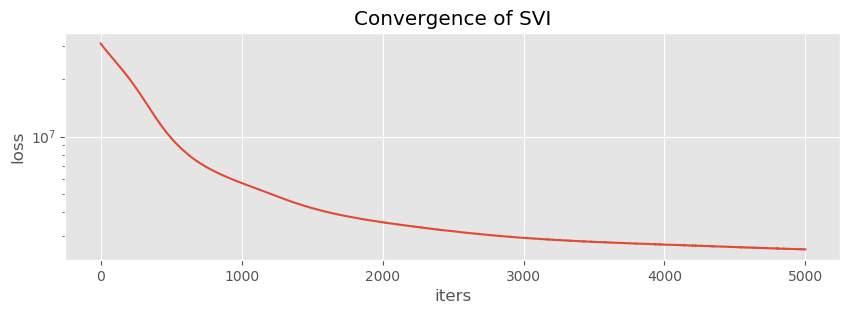

In [ ]:
from matplotlib import pyplot
%matplotlib inline

pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

**Model evaluation**

With a model trained by the trainset, the model is expected to be used to make prediction on the testset for evaluation. To do this, similar as the other notebooks, the classifier is built to predict the testset based on the discrete inference. Effect handlers of *trace*, *replay* and *infer_discrete* in Pyro is used here to build the classfier and read out the cluster assignment results from the model. The trace hanlder here records the relationships amongst different pyro primitives. Each node in the trace includes the name, input and output value of the site. [4]


[4] Trace, https://docs.pyro.ai/en/dev/poutine.html#trace

In [ ]:
guide_trace = poutine.trace(vae.guide).get_trace(X_test_torch)  # record the globals
trained_model = poutine.replay(vae.model, trace=guide_trace)  # replay the globals

def classifier(data, temperature=0):
    inferred_model = infer_discrete(trained_model,temperature=temperature, first_available_dim=-2)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model)
    trace_data = trace.get_trace(data)
    print(trace_data)
    return trace_data.nodes["assignment"]["value"], trace_data.nodes["latent"]["value"]

print(classifier(X_test_torch))

(tensor([0, 1, 1,  ..., 0, 1, 0]), tensor([[ 1.3431,  0.6783, -0.5456,  ..., -0.2275,  0.5856, -0.9945],
        [ 1.5969,  0.8956,  1.3791,  ..., -0.1892,  1.2685, -0.4036],
        [ 1.9981,  2.4150,  0.1369,  ...,  1.8533,  1.1995,  0.7792],
        ...,
        [ 0.6639,  1.8447,  1.4980,  ...,  0.0102, -0.1069, -0.9461],
        [ 2.7381,  0.3504,  0.2269,  ..., -1.8704, -0.8596, -1.0756],
        [ 0.3992,  0.5694, -0.2704,  ...,  0.6856, -1.9128,  0.5802]],
       grad_fn=<AddBackward0>))


In [ ]:
y_pred, y_latent = classifier(X_test_torch)
print(y_pred)

tensor([0, 0, 1,  ..., 0, 0, 1])


**Prediction results**

Detach the prediction results and make a general evalution on the accuracy by comparing the labels between the testset and prediction results. 

The accuracy shows an accuracy of 0.50 which is not as good as the baseline result 0.73 got from sklearn or the results 0.80 got from GMM (K=2).

In [ ]:
y_pred = y_pred.detach().cpu().numpy() 
# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_pred == y_test) / len(y_test))

Accuracy: 0.5067631929891407


To take a closer look at the classification report, the detection on the anomalous samples shows similar performance as GMM (K=2) model, but the detection on the normal samples presents limited but relatively stable performance with a low precision and fair recall score. 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.51      0.62    134730
           1       0.20      0.49      0.28     33238

    accuracy                           0.51    167968
   macro avg       0.50      0.50      0.45    167968
weighted avg       0.68      0.51      0.56    167968



To clearly compare the mixture model, the density estimate and histogram is drawn for both the real case (blue) and predicted case (red). In general, they show a similar pattern with two peaks. But the prediction's histogram shows a relatively spreading shape than the real case's histogram, which indicates the GMVAE still need model improvements and further tuning to obtain a good fit. 

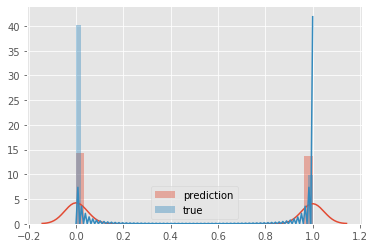

In [ ]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_test, label="true")
plt.legend()
plt.show()